In [19]:
import pandas as pd
import numpy as np
import gc

# data preprocessing

In [2]:
# 读取CSV文件
data = pd.read_csv("data/demo12W_30.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39979422 entries, 0 to 39979421
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pid                 int64  
 1   date                int64  
 2   move_frequency      float64
 3   move_distance       float64
 4   trip_time           float64
 5   home_time           float64
 6   norm_sum            float64
 7   norm_mean           float64
 8   norm_max            float64
 9   norm_home_activity  float64
 10  norm_home_base      float64
 11  group_year          int64  
 12  voluntary           int64  
 13  gender              int64  
 14  age                 int64  
 15  income              float64
dtypes: float64(10), int64(6)
memory usage: 4.8 GB


In [3]:
# interpolation
# 选择日期在20191201到20191231之间的行，并删除重复的行
data_comp = data[data['date'].between(20191201, 20191231)].drop_duplicates(subset=['pid', 'date'])
data = data[~data['date'].between(20191201, 20191231)]
data_comp['group_year'] = 1

# 合并数据
data = pd.concat([data, data_comp], axis=0).sort_values(by=['pid', 'date'])

# NOTE: `na_seadec`是R中的特定函数，需要Python实现或找到相应的Python替代。
# 例如，下面使用pandas的interpolate函数作为替代。
data['norm_mean'] = data.groupby(['pid', 'group_year'])['norm_mean'].transform(lambda x: x.interpolate())

In [4]:
# load weather data
precip = pd.read_csv("data/precipitation.csv")
precip.head()

,date,precip
0,20190101,0.0
1,20190102,0.1
2,20190103,0.0
3,20190104,0.1
4,20190105,0.0


In [5]:
# Adding factors
# Using the query function to filter data
data = data.query('date < 20191201 or date > 20191231')

# Convert date to string then to datetime object and create weekday column
data['datestamp'] = pd.to_datetime(data['date'].astype(str), format="%Y%m%d")
data['weekday'] = data['datestamp'].dt.weekday
data['weekfactor'] = data['weekday'].astype(str)

# Timeline calculations
data['timeline'] = np.where(data['group_year'] == 1, 
                           (data['datestamp'] - pd.Timestamp('2020-01-01')).dt.days, 
                           (data['datestamp'] - pd.Timestamp('2019-01-01')).dt.days)

# Define event and festival
date_conditions = [
    (data['date'].between(20200120, 20200123)),
    (data['date'].between(20200124, 20200223)),
    (data['date'].between(20200224, 20200508)),
    (data['date'] >= 20200509),
    (data['date'].between(20200210, 20200216)),
    (data['date'].between(20200217, 20200223)),
    (data['date'].between(20200321, 20200328)),
    (data['date'].between(20200329, 20200508))
]

event_columns = ['Tran', 'E1', 'E2', 'E3', 'R1', 'R2', 'Low', 'Open']
# Tran：人传人；E1：一级响应；E2：二级响应；E3：三级响应；R1：第一次复工；R2：第二次复工；Low：低风险；Open：公共空间开放

for col, cond in zip(event_columns, date_conditions):
    data[col] = np.where(cond, 1, 0)

# Define tp0 - tp7 columns（代表上述的8个不同时期，不重合）
data['tp0'] = np.where(data['date'].between(20200120, 20200123), 1, 0)
data['tp1'] = np.where(data['date'].between(20200124, 20200209), 1, 0)
data['tp2'] = np.where(data['date'].between(20200210, 20200216), 1, 0)
data['tp3'] = np.where(data['date'].between(20200217, 20200223), 1, 0)
data['tp4'] = np.where(data['date'].between(20200224, 20200320), 1, 0)
data['tp5'] = np.where(data['date'].between(20200321, 20200328), 1, 0)
data['tp6'] = np.where(data['date'].between(20200329, 20200508), 1, 0)
data['tp7'] = np.where(data['date'] >= 20200509, 1, 0)

# Define holidays columns
holidays_conditions = [
    (data['date'].isin([20190101, 20200101])),
    (data['date'].between(20190128, 20190204) | data['date'].between(20200117, 20200124)),
    (data['date'].between(20190204, 20190210) | data['date'].between(20200124, 20200202)),
    (data['date'].between(20190405, 20190407) | data['date'].between(20200404, 20200406)),
    (data['date'].between(20190501, 20190504) | data['date'].between(20200501, 20200505))
]

holidays_columns = ['newyear', 'sprtransp', 'spring', 'tomb', 'labor']
for col, cond in zip(holidays_columns, holidays_conditions):
    data[col] = np.where(cond, 1, 0)
    
# Joining the data and precip DataFrames
data = pd.merge(data, precip, on="date", how="inner")

# Calculating the quantiles for the income column
income_thre = data['income'].quantile(q=[0, 0.2, 0.4, 0.6, 0.8, 1])

# Updating and creating new columns
data['age'] = pd.cut(data['age'], bins=[0, 5, 13, 16, float('inf')], labels=['Young', 'Adult', 'Elder', 'Elder'], right=False,  ordered=False)
data['gender'] = data['gender'].map({1: 'Male', 2: 'Female'})
data['income'] = pd.cut(data['income'], bins=[0] + list(income_thre)[1:], labels=['Bottom', 'Lower', 'Middle', 'Upper', 'Superior'], right=False, include_lowest=True)

data['income3'] = data['income'].map({
    'Bottom': 'Bottom',
    'Superior': 'Upper',
    'Lower': 'Middle',
    'Middle': 'Middle',
    'Upper': 'Middle'
})

# Converting columns to category type with specific levels
data['age'] = data['age'].astype('category')
data['gender'] = data['gender'].astype('category')
data['income'] = pd.Categorical(data['income'], categories=["Bottom", "Lower", "Middle", "Upper", "Superior"], ordered=True)
data['income3'] = pd.Categorical(data['income3'], categories=["Middle", "Bottom", "Upper"], ordered=True)

gc.collect()

26

In [7]:
data.to_csv('data/demo12W_30_processed.csv',index=False)

In [9]:
print(data.isnull().sum())

pid                         0
date                        0
move_frequency              0
move_distance               0
trip_time                   0
home_time                   0
norm_sum              1848403
norm_mean               34600
norm_max              1848403
norm_home_activity    6086872
norm_home_base        2249310
group_year                  0
voluntary                   0
gender                      0
age                         0
income                   6060
datestamp                   0
weekday                     0
weekfactor                  0
timeline                    0
Tran                        0
E1                          0
E2                          0
E3                          0
R1                          0
R2                          0
Low                         0
Open                        0
tp0                         0
tp1                         0
tp2                         0
tp3                         0
tp4                         0
tp5       

# data sampling

In [20]:
data = pd.read_csv('data/demo12W_30_processed.csv')

In [21]:
# Sampling: select 5,000 individuals randomly
sample_it = data['pid'].drop_duplicates().sample(n=5000)
sample_data = data[data['pid'].isin(sample_it)]
#print(sample_data.isnull().sum())

In [22]:
del data
gc.collect()

8

In [23]:
sample_data = sample_data.sort_values(by=['pid', 'date']).reset_index(drop=True)# use yesterday norm_mean as conformity factor
sample_data['conformity'] = sample_data.groupby('pid')['norm_mean'].shift(1)
# fill null in conformity
sample_data['conformity'] = sample_data['conformity'].fillna(0)
sample_data['log_conformity'] = np.log(sample_data['conformity'] + 1)

In [7]:
sample_data['log_conformity']

0          0.000000
1          7.188280
2          7.779820
3          7.698167
4          7.782097
             ...   
3029995    6.017498
3029996    6.016901
3029997    6.872145
3029998    6.027145
3029999    5.981465
Name: log_conformity, Length: 3030000, dtype: float64

In [61]:
# obtain treatment intervals (conformity) using PAM clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# built KMeans class and fit data
X = sample_data['log_conformity'].values.reshape(-1, 1)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

# get cluster labels
labels = kmeans.labels_
sample_data['conformity_class'] = labels

# 获取每个聚类的中心值
cluster_centers = kmeans.cluster_centers_.flatten()

# 根据中心值对标签进行排序
sorted_label_idx = cluster_centers.argsort()

# 创建一个映射
label_mapping = {original_label: new_label for new_label, original_label in enumerate(sorted_label_idx)}

# 更新数据帧的标签
sample_data['conformity_class'] = sample_data['conformity_class'].map(label_mapping)

In [62]:
# 先生成全0array
one_hot = np.zeros([len(sample_data), n_clusters])

for index, label in enumerate(sample_data['conformity_class']):
    one_hot[index, :label+1] = 1

#print(one_hot)
for i in range(n_clusters):
    col_name = 'conformity_label'+str(i)
    sample_data[col_name] = one_hot[:,i]

In [65]:
sample_data.head()

,pid,date,move_frequency,move_distance,trip_time,home_time,norm_sum,norm_mean,norm_max,norm_home_activity,...,precip,income3,conformity,log_conformity,conformity_class,conformity_label0,conformity_label1,conformity_label2,conformity_label3,conformity_label4
0,2576,20190101,0.0,0.0,0.0,24.000,127564.866667,2868.775,3770.0,127564.867,...,0.0,Upper,0.000,0.000000,0,1.0,0.0,0.0,0.0,0.0
1,2576,20190102,0.0,0.0,0.0,24.000,98542.666667,2237.911,2822.0,98542.667,...,0.1,Upper,2868.775,7.961989,4,1.0,1.0,1.0,1.0,1.0
2,2576,20190103,0.0,0.0,0.0,24.000,96103.000000,2089.196,2765.0,96103.000,...,0.0,Upper,2237.911,7.713745,3,1.0,1.0,1.0,1.0,0.0
3,2576,20190104,2.0,30468.0,20047.0,17.285,83283.600000,1826.395,2762.0,68424.900,...,0.1,Upper,2089.196,7.645013,3,1.0,1.0,1.0,1.0,0.0
4,2576,20190105,0.0,0.0,0.0,24.000,109323.200000,2374.870,3248.0,109323.200,...,0.0,Upper,1826.395,7.510647,3,1.0,1.0,1.0,1.0,0.0


In [63]:
print(len(sample_data[sample_data['conformity_class']==0]['conformity']), min(sample_data[sample_data['conformity_class']==0]['conformity']), 
      max(sample_data[sample_data['conformity_class']==0]['conformity']))
print(len(sample_data[sample_data['conformity_class']==1]['conformity']), min(sample_data[sample_data['conformity_class']==1]['conformity']), 
      max(sample_data[sample_data['conformity_class']==1]['conformity']))
print(len(sample_data[sample_data['conformity_class']==2]['conformity']), min(sample_data[sample_data['conformity_class']==2]['conformity']), max(sample_data[sample_data['conformity_class']==2]['conformity']))
print(len(sample_data[sample_data['conformity_class']==3]['conformity']), min(sample_data[sample_data['conformity_class']==3]['conformity']), max(sample_data[sample_data['conformity_class']==3]['conformity']))
print(len(sample_data[sample_data['conformity_class']==4]['conformity']), min(sample_data[sample_data['conformity_class']==4]['conformity']), max(sample_data[sample_data['conformity_class']==4]['conformity']))

15156 0.0 13.906
448665 13.92 288.454
1048103 288.456 824.561
1058300 824.562 2367.063
459776 2367.065 36548.761


In [64]:
print(min(sample_data[sample_data['conformity_class']==0]['log_conformity']), max(sample_data[sample_data['conformity_class']==0]['log_conformity']))
print(min(sample_data[sample_data['conformity_class']==1]['log_conformity']), max(sample_data[sample_data['conformity_class']==1]['log_conformity']))
print(min(sample_data[sample_data['conformity_class']==2]['log_conformity']), max(sample_data[sample_data['conformity_class']==2]['log_conformity']))
print(min(sample_data[sample_data['conformity_class']==3]['log_conformity']), max(sample_data[sample_data['conformity_class']==3]['log_conformity']))
print(min(sample_data[sample_data['conformity_class']==4]['log_conformity']), max(sample_data[sample_data['conformity_class']==4]['log_conformity']))

0.0 2.701763816459502
2.702702594775615 5.667996389742017
5.668003299278905 6.716063155239438
6.7160643665362345 7.769827600379727
7.769828444951495 10.506429926168858


In [6]:
# build conformity class
# 定义边界
bins = [0.0, 2.702, 5.668, 6.716, 7.769, float('inf')]

# 使用cut函数
sample_data['conformity_class'] = pd.cut(sample_data['log_conformity'], bins=bins, labels=[0, 1, 2, 3, 4], right=False)

In [7]:
# 先生成全0array
one_hot = np.zeros([len(sample_data), len(bins)-1])

for index, label in enumerate(sample_data['conformity_class']):
    one_hot[index, :label+1] = 1

#print(one_hot)
for i in range(len(bins)-1):
    col_name = 'conformity_label'+str(i)
    sample_data[col_name] = one_hot[:,i]

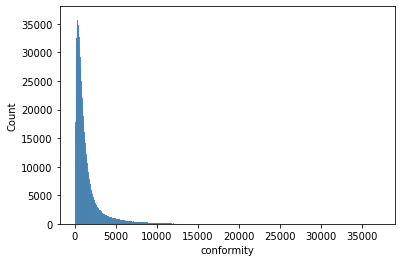

In [41]:
import seaborn as sns
# 直方图
sns.histplot(sample_data['conformity'], kde=False)
plt.show()

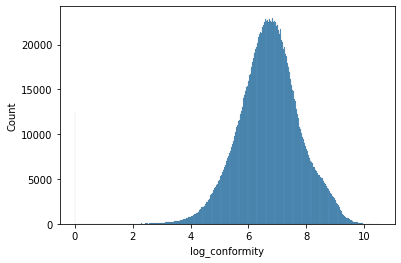

In [40]:
# 直方图
sns.histplot(sample_data['log_conformity'], kde=False)
plt.show()

In [12]:
unique_values, counts = np.unique(sample_data['conformity_class'].values, return_counts=True)

# 将结果打印为类似于 dataframe 的 value_counts 的格式
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 14943
1: 439492
2: 1057498
3: 1072992
4: 445075


In [6]:
sample_data['week'] =  pd.to_datetime(sample_data['date'].astype(str), format="%Y%m%d").dt.isocalendar().week

In [61]:
sample_data.head()

,pid,date,move_frequency,move_distance,trip_time,home_time,norm_sum,norm_mean,norm_max,norm_home_activity,...,newyear,sprtransp,spring,tomb,labor,precip,income3,conformity,conformity_class,week
0,1930,20190101,0.0,0.0,0.0,24.000,10083.266667,713.439,881.0,NaN,...,1,0,0,0,0,0.0,Middle,0.000,0,1
1,1930,20190102,5.0,16453.0,8910.0,12.206,16659.166667,577.107,1001.0,15642.733,...,0,0,0,0,0,0.1,Middle,713.439,0,1
2,1930,20190103,4.0,18527.0,2494.0,13.189,22684.433333,610.891,1091.0,15965.033,...,0,0,0,0,0,0.0,Middle,577.107,0,1
3,1930,20190104,5.0,26393.0,6624.0,5.016,15067.466667,766.142,1173.0,10567.900,...,0,0,0,0,0,0.1,Middle,610.891,0,1
4,1930,20190105,5.0,0.0,4656.0,0.268,9763.033333,999.628,1099.0,475.200,...,0,0,0,0,0,0.0,Middle,766.142,0,1


In [24]:
def features_generation(data):

    # encoding categories
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    ind_attr_cols = ['gender', 'age', 'income3']
    for col in ind_attr_cols:
        data[col] = le.fit_transform(data[col])
    data['income3'] = data['income3'].fillna(0)

    # weekday one-hot encoding
    one_hot_encoded = pd.get_dummies(data['weekday'], prefix='weekday')
    data = data.drop('weekday', axis=1)
    data= pd.concat([data, one_hot_encoded], axis=1)
    # sample_data2020.head()

    # use is_workday
    # from chinese_calendar import is_workday
    # sample_data2020['datestamp'] = pd.to_datetime(sample_data2020['date'].astype(str), format="%Y%m%d")
    # sample_data2020['workday'] = sample_data2020['datestamp'].apply(lambda x: int(is_workday(x)))
    
    # construct policy features
    data['restrict'] = np.where(data['date'].between(20200124, 20200223), 1, 0)
    data['open'] = np.where(data['date'] > 20200223, 1, 0)
    
    return data

In [25]:
# use data in 2019
# sample_data2019 = sample_data.query('date<20200101').reset_index(drop=True)
# sample_data2019 = features_generation(sample_data2019)
# use data in 2020
sample_data2020 = sample_data.query('date>=20200101').reset_index(drop=True)
sample_data2020 = features_generation(sample_data2020)

In [11]:
# 分组并计算每组中的唯一标签数
unique_labels_per_week = sample_data2019.groupby('week')['conformity_class'].nunique()

# 检查每周的标签数是否与所有可能的标签数相匹配
all_labels_count = sample_data2019['conformity_class'].nunique()
weeks_without_all_labels = unique_labels_per_week[unique_labels_per_week < all_labels_count]
print(weeks_without_all_labels)

Series([], Name: conformity_class, dtype: int64)


In [22]:
print(int(len(sample_data2019)/len(sample_data2019['pid'].unique())))

151


In [75]:
print(sample_data2020.isnull().sum())

pid                       0
date                      0
move_frequency            0
move_distance             0
trip_time                 0
home_time                 0
norm_sum              29743
norm_mean               192
norm_max              29743
norm_home_activity    91587
norm_home_base        35706
group_year                0
voluntary                 0
gender                    0
age                       0
income                    0
datestamp                 0
weekfactor                0
timeline                  0
Tran                      0
E1                        0
E2                        0
E3                        0
R1                        0
R2                        0
Low                       0
Open                      0
tp0                       0
tp1                       0
tp2                       0
tp3                       0
tp4                       0
tp5                       0
tp6                       0
tp7                       0
newyear             

# data transformation

covariates：gender, age, income, festivals(newyear, sprtransp, spring, tomb, labor), events(Tran), weekday  
treatments: norm_mean, policy(如何编码？), voluntary(=case)  
outcome: move_distance  
Tran：人传人；E1：一级响应；E2：二级响应；E3：三级响应；R1：第一次复工；R2：第二次复工；Low：低风险；Open：公共空间开放

In [26]:
def normalize_dataset(dataset, num_covariates, num_treatments):

        for covariate_id in range(num_covariates):
            covariate_mean = np.mean(dataset['previous_covariates'][:, :, covariate_id])
            covariate_std = np.std(dataset['previous_covariates'][:, :, covariate_id])
            dataset['previous_covariates'][:, :, covariate_id] = (dataset['previous_covariates'][:, :,
                                                      covariate_id] - covariate_mean) / covariate_std
            # covariate_max = np.max(dataset['previous_covariates'][:, :, covariate_id])
            # covariate_min = np.min(dataset['previous_covariates'][:, :, covariate_id])
            # dataset['previous_covariates'][:, :, covariate_id] = (dataset['previous_covariates'][:, :,
            #                                           covariate_id] - covariate_min) / (covariate_max - covariate_min)

        for covariate_id in range(num_covariates):
            covariate_mean = np.mean(dataset['covariates'][:, :, covariate_id])
            covariate_std = np.std(dataset['covariates'][:, :, covariate_id])
            dataset['covariates'][:, :, covariate_id] = (dataset['covariates'][:, :,
                                                      covariate_id] - covariate_mean) / covariate_std
            # covariate_max = np.max(dataset['covariates'][:, :, covariate_id])
            # covariate_min = np.min(dataset['covariates'][:, :, covariate_id])
            # dataset['covariates'][:, :, covariate_id] = (dataset['covariates'][:, :,
            #                                           covariate_id] - covariate_min) / (covariate_max - covariate_min)
        
        for treatment_id in range(num_treatments):
            treatment_mean = np.mean(dataset['previous_treatments'][:, :, treatment_id])
            treatment_std = np.std(dataset['previous_treatments'][:, :, treatment_id])
            dataset['previous_treatments'][:, :, treatment_id] = (dataset['previous_treatments'][:, :,
                                                      treatment_id] - treatment_mean) / treatment_std
            # use Min-Max scaling
            # treatment_max = np.max(dataset['previous_treatments'][:, :, treatment_id])
            # treatment_min = np.min(dataset['previous_treatments'][:, :, treatment_id])
            # dataset['previous_treatments'][:, :, treatment_id] = (dataset['previous_treatments'][:, :,
            #                                           treatment_id] - treatment_min) / (treatment_max - treatment_min)

        for treatment_id in range(num_treatments):
            treatment_mean = np.mean(dataset['treatments'][:, :, treatment_id])
            treatment_std = np.std(dataset['treatments'][:, :, treatment_id])
            dataset['treatments'][:, :, treatment_id] = (dataset['treatments'][:, :,
                                                      treatment_id] - treatment_mean) / treatment_std
            # use Min-Max scaling
            # treatment_max = np.max(dataset['treatments'][:, :, treatment_id])
            # treatment_min = np.min(dataset['treatments'][:, :, treatment_id])
            # dataset['treatments'][:, :, treatment_id] = (dataset['treatments'][:, :,
            #                                           treatment_id] - treatment_min) / (treatment_max - treatment_min)

        outcome_mean = np.mean(dataset['outcomes'])
        outcome_std= np.std(dataset['outcomes'])
        dataset['outcomes'] = (dataset['outcomes'] - outcome_mean) /outcome_std

        return dataset

def generate_dataset(data, max_timesteps, covariate_cols, treatment_cols, outcome_col, log_transform=False):
            dataset = dict()

            dataset['previous_covariates'] = []
            dataset['previous_treatments'] = []
            dataset['covariates'] = []
            dataset['treatments'] = []
            dataset['sequence_length'] = []
            dataset['outcomes'] = []
            
            timesteps = int(len(data)/len(data['pid'].unique()))
            
            for pid in data['pid'].unique():
                single_data = data[data['pid']==pid].reset_index(drop=True)
                covariates_history = single_data[covariate_cols].values
                treatments_history = single_data[treatment_cols].values
                
                previous_covariates = np.vstack((np.array(covariates_history[1:timesteps - 1]), np.zeros(shape=(max_timesteps-timesteps, len(covariate_cols)))))
                previous_treatments = np.vstack((np.array(treatments_history[1:timesteps - 1]),np.zeros(shape=(max_timesteps-timesteps, len(treatment_cols)))))
                
                covariates = np.vstack((np.array(covariates_history[1:timesteps]),np.zeros(shape=(max_timesteps-timesteps, len(covariate_cols)))))
                treatments = np.vstack((np.array(treatments_history[1:timesteps]),np.zeros(shape=(max_timesteps-timesteps, len(treatment_cols)))))
                
                outcomes = single_data[outcome_col].values[1:timesteps]
                if log_transform:
                    outcomes = np.log(outcomes + 1)
                outcomes = outcomes[:, np.newaxis]
                outcomes = np.vstack((np.array(outcomes), np.zeros(shape=(max_timesteps-timesteps, 1))))
                
                dataset['previous_covariates'].append(np.array(previous_covariates))
                dataset['previous_treatments'].append(np.array(previous_treatments))
                dataset['covariates'].append(np.array(covariates))
                dataset['treatments'].append(np.array(treatments))
                dataset['sequence_length'].append(np.array(timesteps))
                dataset['outcomes'].append(np.array(outcomes))
            
            for key in dataset.keys():
                dataset[key] = np.array(dataset[key])

            return dataset

In [20]:
def compute_mean_std(column):
    if np.all((column == 0) | (column == 1)):
        mean = 0
        std = 1
    else:
        mean = np.mean(column)
        std = np.std(column)
    return mean, std

def get_normalize_params(dataset, num_covariates, num_treatments):
    scale_params = dict()

    for key in ['previous_covariates', 'previous_treatments', 'covariates', 'treatments', 'outcomes']:
        scale_params[key] = []

    for covariate_id in range(num_covariates):

        column = dataset['previous_covariates'][:, :, covariate_id]
        # if feature is [0,1], then mean = 0, std = 1
        pre_covariate_mean, pre_covariate_std = compute_mean_std(column)
        scale_params['previous_covariates'].append(np.array([pre_covariate_mean, pre_covariate_std]))

        column = dataset['covariates'][:, :, covariate_id]
        covariate_mean, covariate_std = compute_mean_std(column)
        scale_params['covariates'].append(np.array([covariate_mean, covariate_std]))

    for treatment_id in range(num_treatments):
        column = dataset['previous_treatments'][:, :, treatment_id]
        pre_treatment_mean, pre_treatment_std = compute_mean_std(column)
        scale_params['previous_treatments'].append(np.array([pre_treatment_mean, pre_treatment_std]))

        column = dataset['treatments'][:, :, treatment_id]
        treatment_mean, treatment_std = compute_mean_std(column)
        scale_params['treatments'].append(np.array([treatment_mean, treatment_std]))

    scale_params['outcomes'].append(np.array([np.mean(dataset['outcomes']), np.std(dataset['outcomes'])]))

    for key in scale_params.keys():
        scale_params[key] = np.array(scale_params[key])

    return scale_params

def get_dataset_normalize(dataset, scale_params, num_covariates, num_treatments):
    for covariate_id in range(num_covariates):
        dataset['previous_covariates'][:, :, covariate_id] = \
            (dataset['previous_covariates'][:, :, covariate_id] - scale_params['previous_covariates'][covariate_id, 0]) / \
            scale_params['previous_covariates'][covariate_id, 1]

        dataset['covariates'][:, :, covariate_id] = \
            (dataset['covariates'][:, :, covariate_id] - scale_params['covariates'][covariate_id, 0]) / \
            scale_params['covariates'][covariate_id, 1]

    for treatment_id in range(num_treatments):
        dataset['previous_treatments'][:, :, treatment_id] = \
            (dataset['previous_treatments'][:, :, treatment_id] - scale_params['previous_treatments'][treatment_id, 0]) / \
            scale_params['previous_treatments'][treatment_id, 1]

        dataset['treatments'][:, :, treatment_id] = \
            (dataset['treatments'][:, :, treatment_id] - scale_params['treatments'][treatment_id, 0]) / \
            scale_params['treatments'][treatment_id, 1]

    dataset['outcomes'] = (dataset['outcomes'] - scale_params['outcomes'][0,0]) /scale_params['outcomes'][0,1]

    return dataset

In [27]:
max_timesteps = int(len(sample_data2020)/len(sample_data2020['pid'].unique()))
covariate_cols = ['gender','age','income3','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
                  'sprtransp','spring','precip', 'voluntary']
treatment_cols = ['log_conformity','restrict','open']
#treatment_cols = ['conformity_label0','conformity_label1','conformity_label2','conformity_label3','conformity_label4','restrict','open']
# treatment_cols = ['restrict','open']
outcome_col = 'move_distance'
dataset2020 = generate_dataset(sample_data2020, max_timesteps, covariate_cols, treatment_cols, outcome_col, True)
#dataset2019 = generate_dataset(sample_data2019, max_timesteps, covariate_cols, treatment_cols, outcome_col, True)

# merge data2020 and data2019
# dataset = dict()
# for key in dataset2020.keys():
#     # if key == 'sequence_length':
#     #     dataset[key] = dataset2019[key].append(dataset2020[key])
#     # else:
#     dataset[key] = np.concatenate((dataset2019[key], dataset2020[key]), axis=0)
#norm_dataset = normalize_dataset(dataset, len(covariate_cols), len(treatment_cols)-2) # treatment仅正则化conformity和voluntary两项

In [14]:
for key in list(dataset2019.keys()):
    print(key)
    print(dataset2019[key].shape)

previous_covariates
(5000, 149, 14)
previous_treatments
(5000, 149, 7)
covariates
(5000, 150, 14)
treatments
(5000, 150, 7)
sequence_length
(5000,)
outcomes
(5000, 150, 1)


In [28]:
for key in list(dataset2020.keys()):
    print(key)
    print(dataset2020[key].shape)

previous_covariates
(5000, 150, 14)
previous_treatments
(5000, 150, 3)
covariates
(5000, 151, 14)
treatments
(5000, 151, 3)
sequence_length
(5000,)
outcomes
(5000, 151, 1)


In [11]:
for key in list(dataset.keys()):
    print(key)
    print(dataset[key].shape)

previous_covariates
(20000, 150, 14)
previous_treatments
(20000, 150, 3)
covariates
(20000, 151, 14)
treatments
(20000, 151, 3)
sequence_length
(20000,)
outcomes
(20000, 151, 1)


In [29]:
# export data
import pickle

def write_results_to_file(filename, data):
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=2)

#write_results_to_file('data/sample10000_logdiscrete_control.txt',dataset)
#write_results_to_file('data/sample5000_for_predict_logdiscrete.txt', dataset2020)
#write_results_to_file('data/sample5000_for_predict_logdiscrete2019.txt', dataset2019)
#write_results_to_file('data/sample10000_log.txt', dataset)
write_results_to_file('data/sample5000_log_for_predict.txt', dataset2020)

In [79]:
features = sample_data2020[covariate_cols+treatment_cols+[outcome_col]]
print(features.isna().sum())

gender           0
age              0
income3          0
workday          0
sprtransp        0
spring           0
precip           0
voluntary        0
conformity       0
restrict         0
open             0
move_distance    0
dtype: int64


In [63]:
iptw = np.load("results/rmsn_sample_10000_gamma_0.6_use_confounders_True/propensity_scores.npy")
iptw.shape

(8010, 150, 1)

In [49]:
print(iptw.min())

-0.27508382828776695


In [41]:
outputs = norm_dataset['outcomes']
sequence_lengths = norm_dataset['sequence_length']
horizon = 1
b_predict_actions = False
active_entries = np.zeros(outputs.shape)
for i in range(sequence_lengths.shape[0]):
    sequence_length = int(sequence_lengths[i])

    if not b_predict_actions:
        for k in range(horizon):
            #include the censoring point too, but ignore future shifts that don't exist
            active_entries[i, :sequence_length-k, k] = 1
    else:
        active_entries[i, :sequence_length, :] = 1

In [43]:
np.sum(active_entries)

1510000.0

In [62]:
def load_data_from_file(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

# 使用函数加载数据
filename = "results/simulated_data/_dataset_with_substitute_confounders.txt"  # 更改为您的文件名
simulated_data = load_data_from_file(filename)
print(simulated_data)

{'previous_covariates': array([[[ 0.4836432 ,  0.14829019, -0.27194955],
        [ 0.21966952,  0.159632  , -0.29473256],
        [ 0.31210715,  0.23716383, -0.18455728],
        ...,
        [-0.01889956, -0.01106907,  0.01809696],
        [-0.02130581,  0.00441948,  0.01511471],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.10181909, -0.16746599,  0.65813375],
        [-0.27828921, -0.08667827,  0.841197  ],
        [-0.37494351,  0.03567515,  0.61385476],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.34463483, -0.25486716, -0.46962224],
        [ 0.10949454, -0.14256839, -0.42181919],
        [ 0.17931144, -0.05347157, -0.10505994],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[-0.28026265,  0.50328932,  

In [85]:
for key in list(simulated_data.keys()):
    print(key)
    print(simulated_data[key].shape)

previous_covariates
(5000, 29, 3)
previous_treatments
(5000, 29, 3)
covariates
(5000, 30, 3)
confounders
(5000, 30, 1)
treatments
(5000, 30, 3)
sequence_length
(5000,)
outcomes
(5000, 30, 1)


In [91]:
print(len(dataset['outcomes'][1,:,:]))
print(dataset['sequence_length'][1])

151
152
